In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import json
from PIL import Image

先撰寫需要之涵式，以及資料前處理。

In [ ]:
class relu(object):
  def __init__(self):
    self.mask = None
  def foward(self,x):
    self.mask = (x<=0)
    out = x.copy()
    out[self.mask] = 0
    return out
  def backward(self,dout):
    dout[self.mask] = 0
    dx = dout
    return dx

class softmax(object):
  def __init__(self):
    pass
  def foward(self,x):
    x = x-np.max(x,axis=1,keepdims=True)
    x = np.exp(x)
    x = x/np.sum(x,axis=1,keepdims=True)
    return x
    # out = (np.exp(z) / (np.sum(np.exp(z), axis=1).reshape(z.shape[0],1)))
    # return out
  def backward(self,dout):
    dx = dout
    return dx



In [ ]:
def label(y):
  return pd.get_dummies(y).values

In [ ]:
class layer(object):
  def __init__(self,input_size,out_size,activator,zero_weight=False):
    self.in_size = input_size
    self.out_size = out_size
    self.activator = activator
    if zero_weight:
      self.weight = np.zeros([self.in_size,self.out_size])
    else:
      self.weight = np.random.uniform(-0.1,0.1,(self.in_size,self.out_size)) #XW
    self.b = np.random.uniform(-0.1,0.1,(1,self.out_size))
  def forward(self,x):
    self.x = x
    self.Y = np.dot(self.x,self.weight)+self.b
    self.output_y = self.activator.foward(self.Y)
  def back(self,delta_y):
    dout_activator = self.activator.backward(delta_y)
    self.delta_x = np.dot(dout_activator,self.weight.T)
    self.delta_w = np.dot(self.x.T,dout_activator)
    self.delta_b = np.sum(dout_activator,axis=0)
    
  def para_update(self,lr):
    self.weight -= (lr/len(self.x))*self.delta_w
    self.b -= (lr/len(self.x))*self.delta_b

In [ ]:
class nets(object):
  def __init__(self,neurons,activators,zero_w):
    self.layers = []
    for i in range(len(neurons)-1):
      self.layers.append(layer(neurons[i],neurons[i+1],activators[i],zero_w))
  def train(self,x_train,y_train,x_test,y_test,lr,batch,epoch):
    self.lr = lr
    self.batch = batch
    self.epoch = epoch
    self.total_accu = []
    self.total_loss = []
    self.total_accu_test = []
    self.total_loss_test = []
    if len(x_train)%batch==0:
      self.mini_batch = len(x_train)//batch
    else:
      self.mini_batch = len(x_train)//batch+1
    for i in range(epoch):
      self.train_accu = 0
      self.train_loss = 0
      self.test_accu = 0
      self.test_loss = 0
      for j in range(self.mini_batch):
        if j == self.mini_batch-1:
          train = x_train[j*batch:,:]
          label = y_train[j*batch:,:]
        else:
          train = x_train[j*batch:j*batch+batch,:]
          label = y_train[j*batch:j*batch+batch,:]
        out = self.predict(train)
        self.train_accu += self.accu(out,label)
        self.train_loss += self.cross(out,label)/len(train)
        dout = out-label
        self.backward(dout)
        self.update()
        out_test = self.predict(x_test)
        self.test_accu += self.accu(out_test,y_test)
        self.test_loss += self.cross(out_test,y_test)/len(x_test)
      self.total_accu.append(self.train_accu/self.mini_batch)
      self.total_loss.append(self.train_loss/self.mini_batch)
      self.total_accu_test.append(self.test_accu/self.mini_batch)
      self.total_loss_test.append(self.test_loss/self.mini_batch)
    return self.total_accu,self.total_loss,self.total_accu_test,self.total_loss_test

  def predict(self,x):
    output = x
    for l in self.layers:
      l.forward(output)
      output = l.output_y
    return output

  def backward(self,dout):
    dy = dout
    for l in self.layers[::-1]:
      l.back(dy)
      dy = l.delta_x
    return dy
  
  def update(self):
    for l in self.layers:
      l.para_update(self.lr)
  
  def accu(self,ylabel,target):
    res = ylabel.argmax(axis=1)
    tar = target.argmax(axis=1)
    accu = 0
    for r,t in zip(res,tar):
      if r==t:
        accu += 1
    return (accu/len(res))
  
  def cross(self,y,t):
    return -np.sum(t*np.log(y))
        

In [ ]:
class nets_new(object):
  def __init__(self,neurons,activators,zero_w):
    self.layers = []
    for i in range(len(neurons)-1):
      self.layers.append(layer(neurons[i],neurons[i+1],activators[i],zero_w))
  def train(self,x_train,y_train,x_test,y_test,lr,batch,epoch):
    self.lr = lr
    self.batch = batch
    self.epoch = epoch
    self.total_accu = []
    self.total_loss = []
    self.total_accu_test = []
    self.total_loss_test = []
    if len(x_train)%batch==0:
      self.mini_batch = len(x_train)//batch
    else:
      self.mini_batch = len(x_train)//batch+1
    for i in range(epoch):
      for j in range(self.mini_batch):
        if j == self.mini_batch-1:
          train = x_train[j*batch:,:]
          label = y_train[j*batch:,:]
        else:
          train = x_train[j*batch:j*batch+batch,:]
          label = y_train[j*batch:j*batch+batch,:]
        out = self.predict(train)
        self.total_accu.append(self.accu(out,label))
        self.total_loss.append(self.cross(out,label)/len(train))
        dout = out-label
        self.backward(dout)
        self.update()
        out_test = self.predict(x_test)
        self.total_accu_test.append(self.accu(out_test,y_test))
        self.total_loss_test.append(self.cross(out_test,y_test)/len(x_test))
    return self.total_accu,self.total_loss,self.total_accu_test,self.total_loss_test

  def predict(self,x):
    output = x
    for l in self.layers:
      l.forward(output)
      output = l.output_y
    return output

  def backward(self,dout):
    dy = dout
    for l in self.layers[::-1]:
      l.back(dy)
      dy = l.delta_x
    return dy
  
  def update(self):
    for l in self.layers:
      l.para_update(self.lr)
  
  def accu(self,ylabel,target):
    res = ylabel.argmax(axis=1)
    tar = target.argmax(axis=1)
    accu = 0
    for r,t in zip(res,tar):
      if r==t:
        accu += 1
    return (accu/len(res))
  
  def cross(self,y,t):
    return -np.sum(t*np.log(y))
        

In [ ]:
def plot_curve(train_accu,test_accu,train_loss,test_loss,nn):
  plt.figure(1)
  plt.title('Accuracy')
  plt.plot(train_accu,color='red',label = 'train')
  plt.plot(test_accu,color='blue',label = 'test')
  plt.legend(loc='best')
  plt.xlabel('Iterations')
  plt.figure(2)
  plt.title('Average Learning curves')
  plt.plot(train_loss,color='red',label = 'train')
  plt.plot(test_loss,color='blue',label = 'test')
  plt.xlabel('Iterations')
  plt.legend(loc='best')
  plt.show()
  print("Batch size :{}\nEpoch:{}\nTraining accuracy:{}\nTesting accuracy:{}\nAverage training loss:{}\nAverage testing loss:{}".format(nn.batch,nn.epoch,nn.total_accu[-1],nn.total_accu_test[-1],nn.total_loss[-1],nn.total_loss_test[-1]))

In [ ]:
a = np.load('train.npz')
b = np.load('test.npz')

In [ ]:
train_x = (a['image'].reshape([len(a['image']),1024]))/255
train_y = label(a['label'])
test_x = (b['image'].reshape([len(b['image']),1024]))/255
test_y = label(b['label'])

1.(a)

In [ ]:
act1 = relu()
act2 = softmax()
activators = [act1,act2]
dims = [1024,512,6]

In [ ]:
# nn = nets_new(dims,activators,False)

In [ ]:
# train_accu,train_loss,test_accu,test_loss = nn.train(train_x,train_y,test_x,test_y,0.01,2048,50)

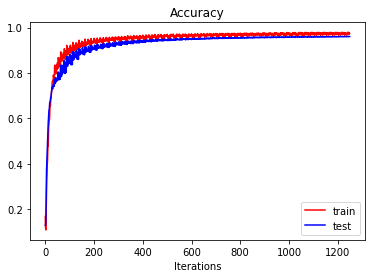

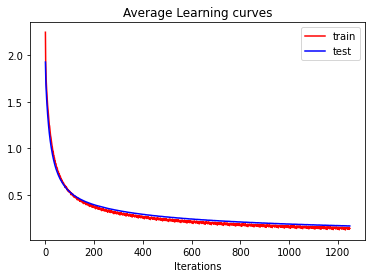

Batch size :2048
Epoch:50
Training accuracy:0.9745670995670995
Testing accuracy:0.9607744531053558
Average training loss:0.14381949558899806
Average testing loss:0.16965251086438807


In [ ]:
# plot_curve(train_accu,test_accu,train_loss,test_loss,nn)

1.(b)

我在第(a)題使用的batch size為2048，因此在此題我選用batch size分別為51000以及1024來做對照。由下圖可發現size為51000的由於迭代次數較少，曲線較不會震盪，但在相同的epoch下收斂速度也沒那麼快，程式執行時間會快一點。而size為1024的由於迭代次數較多，曲線動盪更為明顯，但收斂效果是十分顯著的。

In [ ]:
# nn2 = nets_new(dims,activators,False)

In [ ]:
# train_accu2,train_loss2,test_accu2,test_loss2 = nn2.train(train_x,train_y,test_x,test_y,0.01,51000,50)

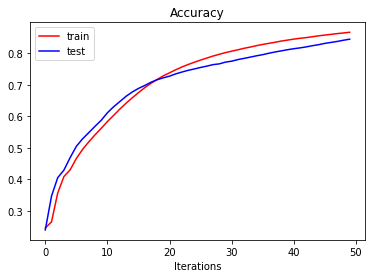

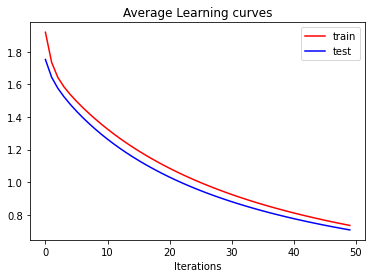

Batch size :51000
Epoch:50
Training accuracy:0.866764705882353
Testing accuracy:0.8447322102087
Average training loss:0.7341645604465148
Average testing loss:0.7065377810113311


In [ ]:
# plot_curve(train_accu2,test_accu2,train_loss2,test_loss2,nn2)

In [ ]:
# nn3 = nets_new(dims,activators,False)

In [ ]:
# train_accu3,train_loss3,test_accu3,test_loss3 = nn3.train(train_x,train_y,test_x,test_y,0.01,1024,50)

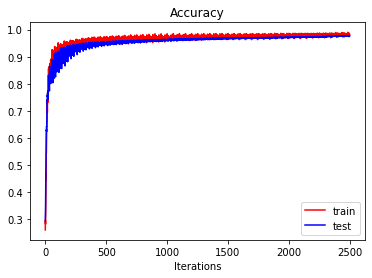

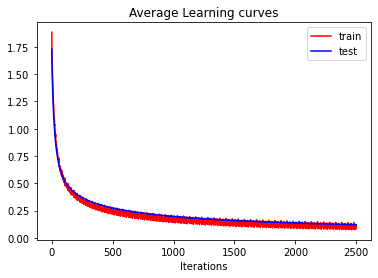

Batch size :1024
Epoch:50
Training accuracy:0.9817961165048543
Testing accuracy:0.976238370631129
Average training loss:0.10419772874323054
Average testing loss:0.12063637337255405


In [ ]:
# plot_curve(train_accu3,test_accu3,train_loss3,test_loss3,nn3)

1.(c)

設定zero_weight後發現模型訓練不出來，我覺得應該是backpropagation的公式中，微分傳回的運算會使用到weight矩陣的運算，但由於值都是0，所以無法更新參數，以至於模型無法訓練。

In [ ]:
# nn_zero_init = nets_new(dims,activators,True)

In [ ]:
# train_accu4,train_loss4,test_accu4,test_loss4 = nn_zero_init.train(train_x,train_y,test_x,test_y,0.01,51000,50)

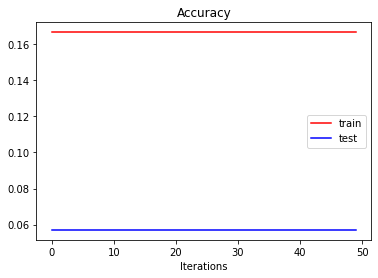

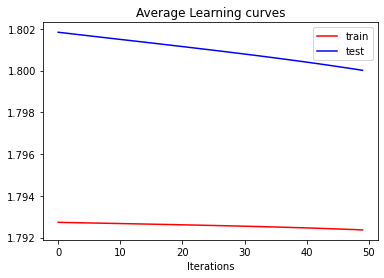

Batch size :51000
Epoch:50
Training accuracy:0.16666666666666666
Testing accuracy:0.057078199647975864
Average training loss:1.7923694767353562
Average testing loss:1.8000165875332657


In [ ]:
# plot_curve(train_accu4,test_accu4,train_loss4,test_loss4,nn_zero_init)

2.(a)

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("-c","--config",help="input the config",dest="con")
parser.add_argument("-w","--weight",help="input the weight",dest="wei")
parser.add_argument("-i","--imgfilelistname",help="input the path of img",dest='im')
args = parser.parse_args()

In [ ]:
with open(args.con,'r') as f:
  con = json.load(f)

TypeError: ignored

In [ ]:
batch = con["batch_size"]
epoch = con['epoch']
lr = con['lr']
nn = con['nn']

In [ ]:
def img_list(t):
  txt = []
  with open(t,'r') as f:
    line = f.readline()
    while line!='':
      txt.append(line)
      line = f.readline()
  new_txt = [l.rstrip('\n') for l in txt]
  return new_txt

In [ ]:
def img(txt):
  res = []
  for i in range(len(txt)):
    img = Image.open(txt[i]).convert('L')
    new_img = np.array(img)/255
    fimg = new_img.reshape(1,1024)
    res.append(fimg)
  return res


In [ ]:
txt = img_list(args.im)

['/content/1.jpeg', '/content/2.jpeg', '/content/3.jpeg']

In [ ]:
img_l = img(txt)

[array([[0.        , 0.        , 0.        , ..., 0.        , 0.01960784,
         0.        ]]),
 array([[0.39607843, 0.39607843, 0.39607843, ..., 0.40784314, 0.4       ,
         0.38823529]]),
 array([[0.24313725, 0.10588235, 0.12941176, ..., 0.10588235, 0.11764706,
         0.12941176]])]

In [ ]:
w = np.load(args.wei)

In [ ]:
def w_list(w):
  weight = []
  for i in w.files:
    weight.append(i)
  return weight

In [ ]:
w_l = w_list(w)


['layer1', 'layer2', 'output']

In [ ]:
def fc(nn):
  layer_list = []
  for key,val in nn.items():
    layer_list.append(val['input_dim'])
    if key == 'output':
      layer_list.append(val['output_dim'])
  return layer_list

In [ ]:
l_l = fc(nn)

[1024, 2048, 512, 6]

In [ ]:
def act(nn):
  act_list = []
  for i in range(len(nn)):
    if i == len(nn)-1:
      act_list.append(softmax())
    else:
      act_list.append(relu())
  return act_list

In [ ]:
a_l = act(nn)

In [ ]:
class layer2(object):
  def __init__(self,input_size,out_size,activator,weight):
    self.in_size = input_size
    self.out_size = out_size
    self.activator = activator
    self.weight = weight
  def forward(self,x):
    self.x = x
    self.Y = np.dot(self.x,self.weight)
    self.output_y = self.activator.foward(self.Y)
  def back(self,delta_y):
    dout_activator = self.activator.backward(delta_y)
    self.delta_x = np.dot(dout_activator,self.weight.T)
    self.delta_w = np.dot(self.x.T,dout_activator)
    
  def para_update(self,lr):
    self.weight -= (lr/len(self.x))*self.delta_w

In [ ]:
class nets2(object):
  def __init__(self,neurons,activators,wn,w_list):
    self.layers = []
    for i in range(len(neurons)-1):
      self.layers.append(layer2(neurons[i],neurons[i+1],activators[i],wn[w_list[i]]))
  def train(self,x_train,y_train,x_test,y_test,lr,batch,epoch):
    self.lr = lr
    self.batch = batch
    self.epoch = epoch
    self.total_accu = []
    self.total_loss = []
    self.total_accu_test = []
    self.total_loss_test = []
    if len(x_train)%batch==0:
      self.mini_batch = len(x_train)//batch
    else:
      self.mini_batch = len(x_train)//batch+1
    for i in range(epoch):
      for j in range(self.mini_batch):
        if j == self.mini_batch-1:
          train = x_train[j*batch:,:]
          label = y_train[j*batch:,:]
        else:
          train = x_train[j*batch:j*batch+batch,:]
          label = y_train[j*batch:j*batch+batch,:]
        out = self.predict(train)
        # self.total_accu.append(self.accu(out,label))
        # self.total_loss.append(self.cross(out,label)/len(train))
        dout = out-label
        self.backward(dout)
        self.update()
        # out_test = self.predict(x_test)
        # self.total_accu_test.append(self.accu(out_test,y_test))
        # self.total_loss_test.append(self.cross(out_test,y_test)/len(x_test))
    return self.total_accu,self.total_loss,self.total_accu_test,self.total_loss_test

  def predict(self,x):
    output = x
    for l in self.layers:
      l.forward(output)
      output = l.output_y
    return output

  def backward(self,dout):
    dy = dout
    for l in self.layers[::-1]:
      l.back(dy)
      dy = l.delta_x
    return dy
  
  def update(self):
    for l in self.layers:
      l.para_update(self.lr)
  
  def accu(self,ylabel,target):
    res = ylabel.argmax(axis=1)
    tar = target.argmax(axis=1)
    accu = 0
    for r,t in zip(res,tar):
      if r==t:
        accu += 1
    return (accu/len(res))
  
  def cross(self,y,t):
    return -np.sum(t*np.log(y))

In [ ]:
nn5 = nets2(l_l,a_l,w,w_l)

In [ ]:
q,w,e,r = nn5.train(train_x,train_y,test_x,test_y,lr,batch,epoch)

In [ ]:
def result(img,nn):
  res = []
  for i in range(len(img)):
    pre = np.argmax(nn.predict(img[i]))
    res.append(pre)
  return res

In [ ]:
final = result(img_l,nn5)

In [ ]:
with open('output.txt','w') as rr:
  for j in final:
    rr.write(str(j))